In [43]:
#load package
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using GenericSchur
using SparseIR
using Zygote
using Optim
using Nevanlinna

In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

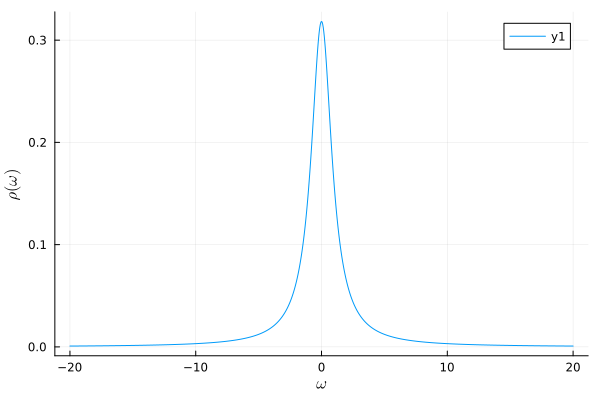

In [3]:
#define spectral function
Lorentzian(x, mu, gamma) = gamma/(pi*((x-mu)^2+gamma^2))
rho(omega) = Lorentzian(omega, 0., 1.0)
omegas = LinRange(-20, 20, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+5
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    input_smpl = Array{Complex{T}}(undef, hnw) 
    ex_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        ex_gw[i]  = 1.0/(input_smpl[i]+im)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw, ex_gw
end

generate_input_data (generic function with 1 method)

In [10]:
beta = 100. #inverse temperature
input_smpl, input_gw, ex_gw = generate_input_data(rho, beta)
;

In [106]:
err = ex_gw - input_gw

69-element Vector{Complex{BigFloat}}:
   2.85658884147255950369017847073570481378e-16 - 5.994395588508828658177823478491275117998e-12im
  3.909158546236681062499934837437739171836e-17 - 1.961202285983853057515991504335895748065e-11im
 -1.733764165487539738611213306039818474683e-16 - 3.309205078253658566313713513927025704897e-11im
 -3.919045959916809429688365140776591553873e-17 - 4.650008553479396630115517179844565684829e-11im
 -1.994589789930154327235600964484149389828e-16 - 5.987929251716299238298830223220449869417e-11im
 -1.455009181914921107491567312133398726737e-17 - 7.324174052980216785400933425637497975051e-11im
  3.110264266433932976464651095501518942566e-16 - 8.659665043425572666169566406609082589301e-11im
 -1.135286673097917184018750132879993391864e-17 - 9.994662962282299831845460966656992342861e-11im
  8.553380725709760963468817300439879586801e-18 - 1.132928367212493709756337991767773744366e-10im
   1.44745755268155624196415453050397371204e-16 - 1.2663514140443566071800532792

In [12]:
((err .- im) ./ (err .+ im))[1:47]
;

In [13]:
cutoff = 49
test_smpl = input_smpl[1:cutoff]
test_gw = input_gw[1:cutoff]
;

In [102]:
function mod_data(wn, gw)
        cutoff = Nevanlinna.calc_opt_N_imag(length(wn),wn,gw)
        cutoff += 1
        while cutoff != length(wn)
                test_smpl = wn[1:cutoff]
                test_gw = gw[1:cutoff]
        
                freq = (test_smpl  .- im) ./ (test_smpl  .+ im)
                val  = (-test_gw .- im) ./ (-test_gw .+ im)
                dval  = 2*im ./ (-test_gw .+ im).^2

                k::Int64 =  cutoff
                #epsl::Complex{T} = 0.0 + 0.0*im
                epsl::T = 0.0
                Pick = Array{Complex{T}}(undef, k, k)
                for j in 1:k
                        for i in 1:k
                                num = one(T) - val[i]  * conj(val[j])
                                den = one(T) - freq[i] * conj(freq[j])
                         Pick[i,j] = num / den
                         end
                end
        
                dPick = zeros(Complex{T}, k, k)
                for j in 1:(k-1)
                        num = - im *dval[k]  * conj(val[j])
                        den = one(T) - freq[k] * conj(freq[j])
                        dPick[k,j] = num / den
                end

                for i in 1:(k-1)
                        num =  im *val[i]  * conj(dval[k])
                        den = one(T) - freq[i] * conj(freq[k])
                        dPick[i,k] = num / den
                end
        
                num = im *val[k]  * conj(dval[k]) - im *dval[k]  * conj(val[k])
                den = one(T) - freq[k] * conj(freq[k])
                dPick[k,k] = num / den
                
                epsl_save::T = 0.0
                eigen = eigvals(Pick)
                while real(eigen[1]) < 0
                        u = eigvecs(Pick)
                        epsl = -real(eigen[1])/real(diag(u' * dPick * u)[1]) + 1e-20
                        Pick = Pick + epsl*dPick
                        epsl_save += epsl
                        eigen = eigvals(Pick)
                        println("eigen:",ComplexF64(eigen[1]))
                        println("eps:",(epsl))
                end
        
                #test_gw[k] = test_gw[k] + im *epsl
                gw[k] = test_gw[k] + im *epsl_save
                
                cutoff += 1
        
    end
end
                

mod_data (generic function with 1 method)

In [103]:
mod_data(input_smpl, input_gw)

eigen:-1.1954357831108633e-28 - 3.1088111462925e-41im
eps:3.530898416751282708958332596611519753664e-12
eigen:-3.642445956790671e-29 - 6.314399873229461e-41im
eps:2.836138195015628197410591924338284328866e-12
eigen:-7.667378091397326e-30 - 6.444552105376383e-42im
eps:1.878860149891255403005382143179095818752e-12
eigen:-5.66317408866223e-31 - 4.818666868609613e-41im
eps:6.422465975183369076763068087470944360829e-13
eigen:-3.670641037158671e-33 - 4.5063923273278806e-41im
eps:5.535666118057371266914795369203279832644e-14
eigen:-6.059482964069861e-38 + 4.0276724941363265e-41im
eps:3.635086786374409544348322686930362172145e-16
eigen:1.0646707398433364e-37 - 2.8883931774407434e-41im
eps:1.600113684297693134448544626878839406638e-20
eigen:-6.319927392613073e-23 - 1.2586528127052252e-42im
eps:-2.37002175529966583340548960471302565403e-11
eigen:-2.1732129281147282e-23 - 4.6928159562493045e-43im
eps:-2.034621537657530753586635187406161708352e-11
eigen:-7.586240464891375e-24 + 3.1472561380480353e

LoadError: InterruptException:

In [85]:
test_gw[k] = test_gw[k] + im *epsl

-7.459601403403975177472344945204193873082e-18 - 0.008568599279540346064117391289303492319314im

In [86]:
N_real    = 1000  #demension of array of output
omega_max = 20.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [ ]:
#construct solver struct
#@time sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
@time sol = Nevanlinna.NevanlinnaSolver(test_smpl, test_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
;

In [56]:
#execute optimize
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     1.518415e-03     1.594443e-13
 * time: 0.00016307830810546875
max_theta=0.02075248006456194294458628141941599665961
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     1.518415e-03     8.239312e-03
 * time: 4.696846008300781e-5
     1     1.515330e-03     5.665439e-03
 * time: 0.14110398292541504
     2     1.514703e-03     5.283725e-03
 * time: 0.2799229621887207
     3     1.415364e-03     4.181092e-03
 * time: 0.518834114074707
     4     1.394738e-03     1.568791e-04
 * time: 0.6514091491699219
     5     1.394737e-03     2.348275e-07
 * time: 0.8336689472198486
     6     1.394737e-03     1.030473e-10
 * time: 0.974635124206543
max_theta=0.03778295534115817790976244200453671650412
hardy optimization was success.
H=3
Iter     Function value   Gradient norm 
     0     1.394737e-03     4.835368e-03
 * time: 0.0001709461212158203
     1     1.394161e-03     3.931945e-03
 * time: 0.148937940597

    30     4.616646e-04     6.295454e-03
 * time: 6.626755952835083
    31     4.608207e-04     7.633607e-03
 * time: 6.797528028488159
    32     4.600645e-04     8.039473e-03
 * time: 6.970273971557617
    33     4.590911e-04     9.465280e-03
 * time: 7.145999908447266
    34     4.581760e-04     9.972246e-03
 * time: 7.322662830352783
    35     4.570351e-04     1.136600e-02
 * time: 7.498283863067627
    36     4.560139e-04     1.191280e-02
 * time: 7.668306827545166
    37     4.547567e-04     1.322365e-02
 * time: 7.905313014984131
    38     4.536217e-04     1.382181e-02
 * time: 8.07878589630127
    39     4.521495e-04     1.497810e-02
 * time: 8.315666913986206
    40     4.508450e-04     1.550886e-02
 * time: 8.48552393913269
    41     4.490984e-04     1.629729e-02
 * time: 8.767082929611206
    42     4.475094e-04     1.664193e-02
 * time: 8.945617914199829
    43     4.450548e-04     1.669674e-02
 * time: 9.190569877624512
    44     4.423337e-04     1.611703e-02
 * time: 

    55     1.193427e-04     2.568780e-04
 * time: 13.161999940872192
    56     1.193405e-04     1.666776e-04
 * time: 13.349072933197021
    57     1.193375e-04     2.916140e-04
 * time: 13.637789011001587
    58     1.193353e-04     2.347588e-04
 * time: 13.823508977890015
    59     1.193316e-04     3.725962e-04
 * time: 14.082082033157349
    60     1.193287e-04     3.270716e-04
 * time: 14.270828008651733
    61     1.193237e-04     4.808739e-04
 * time: 14.557605028152466
    62     1.193197e-04     4.436355e-04
 * time: 14.7413010597229
    63     1.193130e-04     6.226418e-04
 * time: 14.999806880950928
    64     1.193078e-04     5.847482e-04
 * time: 15.186882019042969
    65     1.192990e-04     7.920996e-04
 * time: 15.51695203781128
    66     1.192922e-04     7.591471e-04
 * time: 15.717710971832275
    67     1.192809e-04     9.770706e-04
 * time: 15.993489980697632
    68     1.192725e-04     9.564086e-04
 * time: 16.18929696083069
    69     1.192581e-04     1.189720e-

    34     3.968154e-05     8.422819e-04
 * time: 8.4080228805542
    35     3.964683e-05     1.236193e-03
 * time: 8.683349847793579
    36     3.962069e-05     1.109898e-03
 * time: 8.882682800292969
    37     3.958622e-05     1.428658e-03
 * time: 9.20497989654541
    38     3.956105e-05     1.342069e-03
 * time: 9.402122974395752
    39     3.952655e-05     1.602794e-03
 * time: 9.677165985107422
    40     3.950282e-05     1.536963e-03
 * time: 9.875349998474121
    41     3.946658e-05     1.750039e-03
 * time: 10.189741849899292
    42     3.944242e-05     1.718791e-03
 * time: 10.385331869125366
    43     3.939280e-05     1.787843e-03
 * time: 10.69664978981018
    44     3.933583e-05     1.720200e-03
 * time: 10.973296880722046
    45     3.902088e-05     1.732098e-03
 * time: 11.373239994049072
    46     3.895962e-05     5.532056e-04
 * time: 11.570892810821533
    47     3.890416e-05     4.853528e-04
 * time: 11.883793830871582
    48     3.889378e-05     4.975813e-04
 * t

   154     3.765233e-05     4.277715e-04
 * time: 34.2143988609314
   155     3.765114e-05     4.425728e-04
 * time: 34.41382598876953
   156     3.764984e-05     4.812913e-04
 * time: 34.6148738861084
   157     3.764855e-05     4.963779e-04
 * time: 34.812368869781494
   158     3.764714e-05     5.368058e-04
 * time: 35.01219081878662
   159     3.764574e-05     5.531938e-04
 * time: 35.2069878578186
   160     3.764420e-05     5.941396e-04
 * time: 35.40294289588928
   161     3.764267e-05     6.118029e-04
 * time: 35.600722789764404
   162     3.764101e-05     6.531134e-04
 * time: 35.796875
   163     3.763934e-05     6.719719e-04
 * time: 35.99065089225769
   164     3.763753e-05     7.135374e-04
 * time: 36.187177896499634
   165     3.763572e-05     7.334572e-04
 * time: 36.38642978668213
   166     3.763374e-05     7.751761e-04
 * time: 36.58801579475403
   167     3.763177e-05     7.960076e-04
 * time: 36.79071092605591
   168     3.762959e-05     8.377014e-04
 * time: 36.986

   275     3.738377e-05     3.740891e-06
 * time: 58.92959499359131
   276     3.738377e-05     5.010538e-06
 * time: 59.123236894607544
   277     3.738377e-05     3.552110e-06
 * time: 59.32048797607422
   278     3.738377e-05     4.623836e-06
 * time: 59.51722478866577
   279     3.738377e-05     3.295284e-06
 * time: 59.719034910202026
   280     3.738377e-05     4.240213e-06
 * time: 59.915974855422974
   281     3.738377e-05     2.992186e-06
 * time: 60.11619687080383
   282     3.738376e-05     3.874009e-06
 * time: 60.31039881706238
   283     3.738376e-05     2.665157e-06
 * time: 60.50806999206543
   284     3.738376e-05     3.538784e-06
 * time: 60.70751881599426
   285     3.738376e-05     2.337049e-06
 * time: 60.93566393852234
   286     3.738376e-05     3.246051e-06
 * time: 61.13349795341492
   287     3.738376e-05     2.048159e-06
 * time: 61.32860779762268
   288     3.738376e-05     3.003934e-06
 * time: 61.526202917099
   289     3.738376e-05     2.024283e-06
 * tim

   396     3.738374e-05     2.499724e-07
 * time: 83.56641888618469
   397     3.738374e-05     2.040643e-07
 * time: 83.76640486717224
   398     3.738374e-05     2.447809e-07
 * time: 83.9629647731781
   399     3.738374e-05     2.043064e-07
 * time: 84.15992498397827
   400     3.738374e-05     2.386322e-07
 * time: 84.35611581802368
   401     3.738374e-05     2.015167e-07
 * time: 84.55255079269409
   402     3.738374e-05     2.307809e-07
 * time: 84.74627089500427
   403     3.738374e-05     1.958163e-07
 * time: 84.93980884552002
   404     3.738374e-05     2.213627e-07
 * time: 85.13870978355408
   405     3.738374e-05     1.874293e-07
 * time: 85.33731484413147
   406     3.738374e-05     2.108180e-07
 * time: 85.54253578186035
   407     3.738374e-05     1.766636e-07
 * time: 85.74183392524719
   408     3.738374e-05     2.008616e-07
 * time: 85.93904876708984
   409     3.738374e-05     1.638933e-07
 * time: 86.1370279788971
   410     3.738374e-05     1.896677e-07
 * time: 

     5     3.697983e-05     8.863935e-04
 * time: 1.1595029830932617
     6     3.675341e-05     3.923118e-04
 * time: 1.3668348789215088
     7     3.667999e-05     1.446909e-03
 * time: 1.5716710090637207
     8     3.654657e-05     8.774192e-04
 * time: 1.7725369930267334
     9     3.602902e-05     9.037563e-04
 * time: 1.976038932800293
    10     3.581955e-05     1.242110e-03
 * time: 2.3073229789733887
    11     3.546263e-05     3.066065e-03
 * time: 2.6284658908843994
    12     3.519357e-05     1.233435e-03
 * time: 2.832486867904663
    13     3.472324e-05     2.992213e-03
 * time: 3.122933864593506
    14     3.437840e-05     1.500933e-03
 * time: 3.330091953277588
    15     3.396259e-05     2.932137e-03
 * time: 3.656829833984375
    16     3.369739e-05     1.791494e-03
 * time: 3.8603010177612305
    17     3.341541e-05     2.892927e-03
 * time: 4.188095808029175
    18     3.324234e-05     1.996443e-03
 * time: 4.398360013961792
    19     3.305754e-05     2.525508e-03


   125     2.662164e-05     1.348137e-03
 * time: 30.12617588043213
   126     2.660567e-05     1.326693e-03
 * time: 30.3471360206604
   127     2.658800e-05     1.293840e-03
 * time: 30.55776596069336
   128     2.657148e-05     1.294887e-03
 * time: 30.76578688621521
   129     2.655435e-05     1.218017e-03
 * time: 30.975299835205078
   130     2.653906e-05     1.241900e-03
 * time: 31.180558919906616
   131     2.652368e-05     1.134382e-03
 * time: 31.386199951171875
   132     2.651017e-05     1.178178e-03
 * time: 31.596889972686768
   133     2.649627e-05     1.052446e-03
 * time: 31.805052995681763
   134     2.648384e-05     1.110579e-03
 * time: 32.01494479179382
   135     2.647060e-05     9.813196e-04
 * time: 32.25265192985535
   136     2.645861e-05     1.037278e-03
 * time: 32.46079683303833
   137     2.644590e-05     9.140823e-04
 * time: 32.67044687271118
   138     2.643452e-05     9.590907e-04
 * time: 32.87890291213989
   139     2.642286e-05     8.313016e-04
 * 

   246     2.619588e-05     2.509159e-04
 * time: 55.70204401016235
   247     2.619523e-05     2.781050e-04
 * time: 55.90363097190857
   248     2.619463e-05     2.513880e-04
 * time: 56.10828685760498
   249     2.619400e-05     2.778884e-04
 * time: 56.31495380401611
   250     2.619342e-05     2.550167e-04
 * time: 56.52548885345459
   251     2.619281e-05     2.786257e-04
 * time: 56.76360583305359
   252     2.619225e-05     2.587769e-04
 * time: 56.97102689743042
   253     2.619166e-05     2.798295e-04
 * time: 57.18030285835266
   254     2.619112e-05     2.623303e-04
 * time: 57.3913848400116
   255     2.619055e-05     2.781569e-04
 * time: 57.60370182991028
   256     2.619003e-05     2.638417e-04
 * time: 57.80876302719116
   257     2.618949e-05     2.732445e-04
 * time: 58.01112699508667
   258     2.618899e-05     2.623279e-04
 * time: 58.21647500991821
   259     2.618847e-05     2.654789e-04
 * time: 58.423786878585815
   260     2.618798e-05     2.577773e-04
 * time

   367     2.616961e-05     1.277672e-04
 * time: 81.26749682426453
   368     2.616944e-05     1.182229e-04
 * time: 81.46921682357788
   369     2.616925e-05     1.281045e-04
 * time: 81.67709589004517
   370     2.616907e-05     1.163543e-04
 * time: 81.88848781585693
   371     2.616887e-05     1.279924e-04
 * time: 82.09577798843384
   372     2.616867e-05     1.141980e-04
 * time: 82.30077290534973
   373     2.616847e-05     1.273254e-04
 * time: 82.50249290466309
   374     2.616826e-05     1.123077e-04
 * time: 82.70670795440674
   375     2.616804e-05     1.261767e-04
 * time: 82.91836094856262
   376     2.616781e-05     1.107013e-04
 * time: 83.12846994400024
   377     2.616758e-05     1.256173e-04
 * time: 83.33626794815063
   378     2.616734e-05     1.123221e-04
 * time: 83.57326889038086
   379     2.616710e-05     1.251452e-04
 * time: 83.77904796600342
   380     2.616685e-05     1.149687e-04
 * time: 83.99092197418213
   381     2.616659e-05     1.247722e-04
 * time

   488     2.613970e-05     7.857350e-05
 * time: 107.03988599777222
   489     2.613957e-05     8.949206e-05
 * time: 107.24417281150818
   490     2.613943e-05     8.101812e-05
 * time: 107.45033979415894
   491     2.613930e-05     9.171752e-05
 * time: 107.65688800811768
   492     2.613917e-05     8.336660e-05
 * time: 107.86632680892944
   493     2.613903e-05     9.380895e-05
 * time: 108.07478380203247
   494     2.613890e-05     8.561347e-05
 * time: 108.28323698043823
   495     2.613877e-05     9.576203e-05
 * time: 108.52066493034363
   496     2.613864e-05     8.775446e-05
 * time: 108.73116183280945
   497     2.613852e-05     9.757385e-05
 * time: 108.94129490852356
   498     2.613839e-05     8.978640e-05
 * time: 109.15024089813232
   499     2.613826e-05     9.924297e-05
 * time: 109.35782980918884
   500     2.613813e-05     9.170719e-05
 * time: 109.56637787818909
   501     2.613801e-05     1.007693e-04
 * time: 109.77283692359924
   502     2.613788e-05     9.3515

   607     2.612766e-05     7.164563e-05
 * time: 132.21824383735657
   608     2.612760e-05     7.493270e-05
 * time: 132.42302298545837
   609     2.612753e-05     7.098454e-05
 * time: 132.63146090507507
   610     2.612746e-05     7.415810e-05
 * time: 132.84238386154175
   611     2.612739e-05     7.027394e-05
 * time: 133.07919788360596
   612     2.612732e-05     7.331814e-05
 * time: 133.2820429801941
   613     2.612725e-05     6.951270e-05
 * time: 133.48708200454712
   614     2.612719e-05     7.241123e-05
 * time: 133.69695687294006
   615     2.612712e-05     6.872188e-05
 * time: 133.9075789451599
   616     2.612705e-05     7.143699e-05
 * time: 134.11211681365967
   617     2.612699e-05     6.808150e-05
 * time: 134.31647491455078
   618     2.612692e-05     7.039637e-05
 * time: 134.5225818157196
   619     2.612685e-05     6.736853e-05
 * time: 134.73151993751526
   620     2.612679e-05     6.929161e-05
 * time: 134.94267296791077
   621     2.612672e-05     6.658703e

   727     2.612067e-05     7.554797e-05
 * time: 157.79204392433167
   728     2.612062e-05     7.161808e-05
 * time: 158.02831482887268
   729     2.612058e-05     7.576655e-05
 * time: 158.24062490463257
   730     2.612053e-05     7.202677e-05
 * time: 158.45349979400635
   731     2.612049e-05     7.590688e-05
 * time: 158.66099381446838
   732     2.612045e-05     7.236400e-05
 * time: 158.86752891540527
   733     2.612040e-05     7.597274e-05
 * time: 159.0722529888153
   734     2.612036e-05     7.263221e-05
 * time: 159.27658486366272
   735     2.612031e-05     7.596831e-05
 * time: 159.48449182510376
   736     2.612027e-05     7.283415e-05
 * time: 159.69657588005066
   737     2.612023e-05     7.589808e-05
 * time: 159.90551781654358
   738     2.612019e-05     7.297280e-05
 * time: 160.14503979682922
   739     2.612014e-05     7.576668e-05
 * time: 160.34705781936646
   740     2.612010e-05     7.305130e-05
 * time: 160.55565690994263
   741     2.612006e-05     7.55787

   847     2.611609e-05     4.477622e-05
 * time: 183.16987299919128
   848     2.611606e-05     4.515329e-05
 * time: 183.39519691467285
   849     2.611603e-05     4.427437e-05
 * time: 183.61640787124634
   850     2.611600e-05     4.443432e-05
 * time: 183.8414089679718
   851     2.611597e-05     4.381681e-05
 * time: 184.05163192749023
   852     2.611594e-05     4.375551e-05
 * time: 184.2744619846344
   853     2.611591e-05     4.340973e-05
 * time: 184.49653792381287
   854     2.611588e-05     4.312422e-05
 * time: 184.70492792129517
   855     2.611585e-05     4.305890e-05
 * time: 184.94394302368164
   856     2.611582e-05     4.254740e-05
 * time: 185.1503279209137
   857     2.611579e-05     4.276954e-05
 * time: 185.36084485054016
   858     2.611576e-05     4.203145e-05
 * time: 185.57008695602417
   859     2.611573e-05     4.254615e-05
 * time: 185.77675890922546
   860     2.611570e-05     4.158206e-05
 * time: 185.98318481445312
   861     2.611567e-05     4.239245e

   967     2.611307e-05     4.412476e-05
 * time: 210.679790019989
   968     2.611305e-05     4.457525e-05
 * time: 210.93052291870117
   969     2.611303e-05     4.384049e-05
 * time: 211.21378302574158
   970     2.611301e-05     4.443069e-05
 * time: 211.54114484786987
   971     2.611299e-05     4.357748e-05
 * time: 211.78728485107422
   972     2.611297e-05     4.430163e-05
 * time: 212.04470801353455
   973     2.611295e-05     4.333386e-05
 * time: 212.26025390625
   974     2.611293e-05     4.418503e-05
 * time: 212.48025798797607
   975     2.611291e-05     4.310708e-05
 * time: 212.73078179359436
   976     2.611289e-05     4.407707e-05
 * time: 212.96044301986694
   977     2.611287e-05     4.289397e-05
 * time: 213.1896049976349
   978     2.611285e-05     4.397329e-05
 * time: 213.40212082862854
   979     2.611283e-05     4.269079e-05
 * time: 213.62355089187622
   980     2.611281e-05     4.386868e-05
 * time: 213.84467101097107
   981     2.611279e-05     4.249335e-05

In [104]:
#wo_sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
wo_sol = Nevanlinna.NevanlinnaSolver(test_smpl, test_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 48


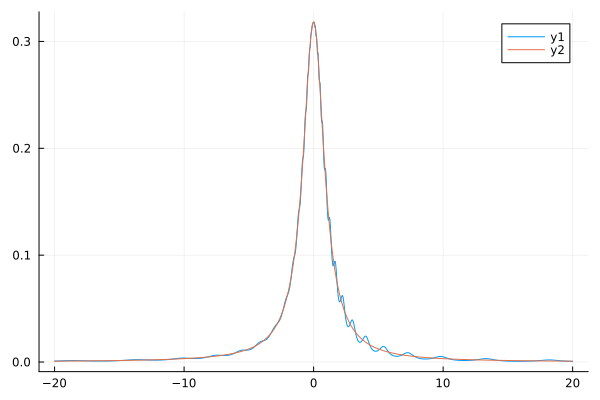

In [105]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
#plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [ ]:
plot(xlim = [-6,6],
    legend = :topright,
    #ymirror = true, 
    xticks = [5,0,-5],
    yticks = [0.3,0,-0.3],
    xtickfont=font(15), 
    ytickfont=font(15), 
    guidefont=font(25), 
    legendfont=font(20))
plot!(xlabel=latexstring("\\omega"))
plot!(ylabel=latexstring("\\rho"))
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val/pi),label="non-opt",lw=3)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)/pi),label="opt",lw=3)
plot!(omegas, rho.(omegas), label="exact",lw=1.5,ls=:dash,lc=:black)
savefig("two_peak.svg")